In [2]:
### Converting shape files with vectors into raster file with distance to vector
# Points within vector / on border are value 0
# Resolution of 30 m


# Load vector shape file
import geopandas as gpd
import rasterio
from rasterio.mask import mask

from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely.geometry import box
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Load the shapefile
gdf = gpd.read_file("capas/antropico/Red_Vial/redvial2019.shp")
gdf = gdf.to_crs(epsg=32719)
region_bounds = gdf.total_bounds 
minx, miny, maxx, maxy = region_bounds

In [21]:
# Define region of interest
# Araucania, BioBio, Coquimbo, Ohiggins, Maule, Metropolitana, Valparaiso, Nuble
regions = gpd.read_file("Regiones/Regional.shp")
regions = regions.to_crs(epsg=32719)

output_path = 'capas/antropico/distance_to_camino_ML.tif'

#regions = regions.to_crs("EPSG:4326") 
#included_regions = ['Región de Coquimbo','Región de Valparaíso','Región Metropolitana de Santiago','Región de La Araucanía','Región del Bío-Bío','Región de Ñuble','Región del Maule']
included_regions = ["Región del Maule"]

regions = regions[regions['Region'].isin(included_regions)] 

minx, miny, maxx, maxy = regions.total_bounds

In [22]:
regions

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
14,1098,9,7,30321.890658,4.596943e+10,1.388328e+06,Región del Maule,"POLYGON ((222018.534 6157438.504, 222022.073 6..."


In [23]:
# Resolution to 30 m
resolution = 30  # 30 meters per pixel

width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)
transform = from_origin(minx, maxy, resolution, resolution)



In [24]:
regions

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
14,1098,9,7,30321.890658,4.596943e+10,1.388328e+06,Región del Maule,"POLYGON ((222018.534 6157438.504, 222022.073 6..."


In [25]:
# For valparaiso only - to exclude the islands

#from shapely.geometry import box
#bbox = box(0,  6195203.63903423,   407513.86185809,
 #       7044568.05015099)  # left, bottom, right, top

# Intersect region with bounding box to remove islands
#regions = regions[regions.intersects(bbox)]
#regions = regions.intersection(bbox)
#regions = gpd.GeoDataFrame(geometry=regions, crs=regions.crs)
#regions.plot()

#minx, miny, maxx, maxy = regions.total_bounds
# Resolution to 30 m
#resolution = 30  # 30 meters per pixel

#width = int((maxx - minx) / resolution)
#height = int((maxy - miny) / resolution)
#transform = from_origin(minx, maxy, resolution, resolution)


In [26]:
# Rasterize populated areas
populated_raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

/Users/abbystokes/anaconda3/envs/geoai/lib/python3.10/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 357329 will not be rasterized.
  warnings.warn(
/Users/abbystokes/anaconda3/envs/geoai/lib/python3.10/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape None at index 359663 will not be rasterized.
  warnings.warn(


In [27]:
populated_raster.shape

(6817, 7429)

In [28]:
# Distance transform --- note this is O(n^2), kernel will crash if populated raster is too large
distance = distance_transform_edt(populated_raster == 0) * resolution


In [29]:

# Save to a new raster
out_meta = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,
    'dtype': 'float32',
    'crs': gdf.crs,
    'transform': transform
}

with rasterio.open(output_path, "w", **out_meta) as dst:
    dst.write(distance.astype(np.float32), 1)

In [30]:

# Crop to region
# Reproject region to match raster CRS
with rasterio.open(output_path) as src:
    raster_crs = src.crs
    regions = regions.to_crs(raster_crs)

    # Mask the raster using the region polygon
    out_image, out_transform = mask(src, regions.geometry, crop=True, nodata=np.nan)

    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": np.nan
    })

# Save the masked raster
with rasterio.open(output_path, "w", **out_meta) as dst:
    dst.write(out_image)

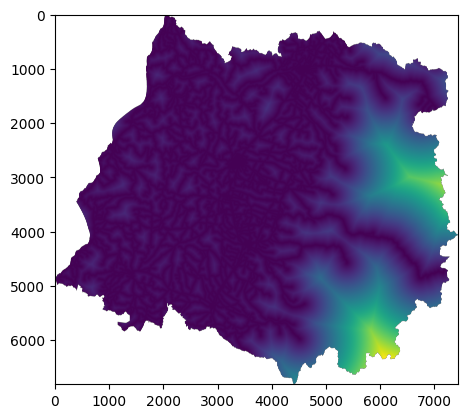

In [31]:

raster = rasterio.open(output_path)
plt.imshow(raster.read(1))